![PUBG_Logo](assets/PUBG_logo.png)

## Objective
* Employ Prinicpal Components Analyis using all features on dataset.
* Employ K-means clustering algorithm on dataset.
* Discuss pertinent results.

## Background Information
* Playerunknown's Battleground (PUBG) is a video game, which set the standard for preceding games in the Battle Royale Genre. The main goal is to SURVIVE at all costs.

## Process:
* Exploratory Data Analysis conducted utilizing various python packages (Numpy, Matplotlib, Pandas, and Plotly).
* Principal Components Analysis (Sci-Kit Learn)
* K-means clustering algorithm (Sci-Kit Learn)


## Table of Contents:
* Part I: Exploratory Data Analysis
    * EDA
* Part II: PCA / K-means Clustering
    * Two Clusters
    * Four Clusters



In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

# PART I - Exploratory Data Analysis

### Data Preprocessing / Feature Engineering

Let us begin by reading in the CSV file containing the data, and examining the data contents such as the number of features and rows. It seems there are 152 column entries (features) and 87898 row entries (number of samples).

In [2]:
#--------- Pandas Dataframe
## Read in CSV
orig = pd.read_csv('data/PUBG_Player_Statistics.csv')

Now, let us remove and combine features, which do not pertain to our goal of clustering solo player behavior. 

Remove:
* player_name
* tracker_id
* duo
* squad

Add:
* Total Distance

This can be achieved by removing all columns after the 52nd. Also, create a new feature that combines the walking and riding distance.

Also, we will reduce the variance in the data by removing players with less than the mean number of rounds in our data.

In [3]:
#---------Preprocessing
## Create a copy of the dataframe
df = orig.copy()
cols = np.arange(52, 152, 1)

# Drop entries if they have null values
df.dropna(inplace = True)

## Drop columns after the 52nd index
df.drop(df.columns[cols], axis = 1, inplace = True)

## Drop player_name and tracker id
df.drop(df.columns[[0, 1]], axis = 1, inplace = True)

## Drop Knockout and Revives
df.drop(df.columns[[49]], axis = 1, inplace = True)
df.drop(columns = ['solo_Revives'], inplace = True)

## Drop the string solo from all strings
df.rename(columns = lambda x: x.lstrip('solo_').rstrip(''), inplace = True)

## Combine a few columns 
df['TotalDistance'] = df['WalkDistance'] + df['RideDistance']
df['AvgTotalDistance'] = df['AvgWalkDistance'] + df['AvgRideDistance']

# Remove Outliers
df = df.drop(df[df['RoundsPlayed'] < df['RoundsPlayed'].mean()].index)

Split the data into three sets: train, dev, and test set.

In [4]:
# Create train and test set using Sci-Kit Learn
train, test = train_test_split(df, test_size=0.3, random_state = 10)
dev, test = train_test_split(test, test_size = 0.2, random_state = 10)
data = train

print("The number of training samples is", len(train))
print("The number of development samples is", len(dev))
print("The number of testing samples is", len(test))

The number of training samples is 20771
The number of development samples is 7121
The number of testing samples is 1781


It is important we go through the final output to make sure that are data preprocessing is complete. And it looks great!

In [5]:
with pd.option_context('display.max_columns', 52):
    print(data.describe(include = 'all'))

       KillDeathRatio      WinRatio  TimeSurvived  RoundsPlayed          Wins  \
count    20771.000000  20771.000000  2.077100e+04  20771.000000  20771.000000   
mean         1.289158      2.204012  1.484172e+05    174.985894      3.554475   
std          0.602602      2.510500  9.339460e+04    113.147056      4.939222   
min          0.100000      0.000000  3.813548e+04     80.000000      0.000000   
25%          0.900000      0.680000  9.091498e+04    104.000000      1.000000   
50%          1.160000      1.460000  1.195404e+05    139.000000      2.000000   
75%          1.520000      2.910000  1.733681e+05    205.000000      4.000000   
max         17.410000     40.210000  1.219536e+06   1552.000000    102.000000   

       WinTop10Ratio        Top10s    Top10Ratio        Losses        Rating  \
count   20771.000000  20771.000000  20771.000000  20771.000000  20771.000000   
mean        0.138708     23.884743     14.369067    171.431419   2059.159131   
std         0.137145     19.21

# PART 2 - PCA / Clustering

#### Procedure
* PCA
* K-means
    * Two Clusters
    * Four Clusters


Feature scaling is utilized to make sure all features are normalized and have similar orders of magnitude. This is important because our clustering algorithms and PCA look into calculating the distance between points. In our case, we employed a zero-mean and unit-variance scaling.

In [6]:
# Scale the data (Normalize)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(train)
X_dev_std = scaler.transform(dev)
X_test_std = scaler.transform(test)

### Principal Components Analysis

The Principal Component Analysis is a dimensional reduction technique that preserves the essence of the original data. Having multi-dimensional data (many features), it is very important in identifying which features are important. PCA finds a new set of dimensions (or a set of basis of views) such that all the dimensions are orthogonal (and hence linearly independent) and ranked according to the variance of data along with them.


#### Algorithm 
1. Calculate the covariance matrix X of data points.
2. Calculate eigenvectors and corresponding eigen values.
3. Sort the eigenvectors according to their eigen values in decreasing order.
4. Choose first k eigen vectors and that will be the new k dimensions.
5. Transform the original n dimensional data points into k dimensions.


#### Parameters

PCA has one parameter:
* Number of components



#### Optimal Number of Components

Now, we'll want to identify the optimal number of principal components. We'll plot the cumulative distribution of variance across several principal components, and identify the number of components that describe 85% of the variance in the data.

Our data suggests 0 - 11 components describe the data, thus a total of 12 components will be used.

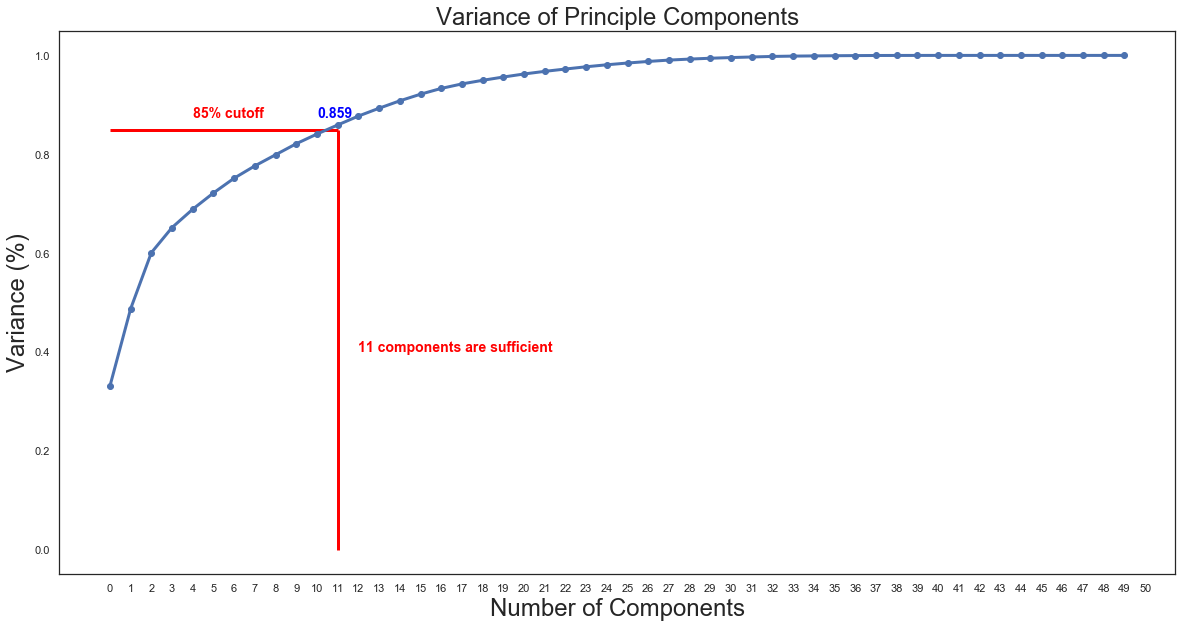

In [32]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_std)
pca_variance_components = np.cumsum(pca.explained_variance_ratio_)

# Plotting the Cumulative Summation of the Explained Variance
## Plot Parameters
plt.figure(figsize=(20,10))
plt.plot(pca_variance_components, '-o')
plt.xlabel('Number of Components', fontsize = 24)
plt.xticks(range(0,51))
plt.ylabel('Variance (%)', fontsize = 24) 
plt.title('Variance of Principle Components', fontsize = 24)

## Annotate plot 
plt.text(4, pca_variance_components[11] + 0.015,
         '85% cutoff', size = 14, color = 'red', weight = 'semibold')


plt.hlines(y = 0.85, color='red', linestyle = '-', xmin = 0.0, xmax = 11)

plt.text(10, pca_variance_components[11] + 0.015,
         str(round(pca_variance_components[11], 3)), size = 14, color = 'blue', weight = 'semibold')

plt.text(12, 0.4,
         '11 components are sufficient', size = 14, color = 'red', weight = 'semibold')

plt.vlines(x=11, color='red', linestyle = '-', ymin = 0.0, ymax = 0.85)

plt.show()

Let's see how the variance is distributed across our components. We identify that 3-4 components contain most of variance (~60%), so we'll examine those first four components in our visualizations.

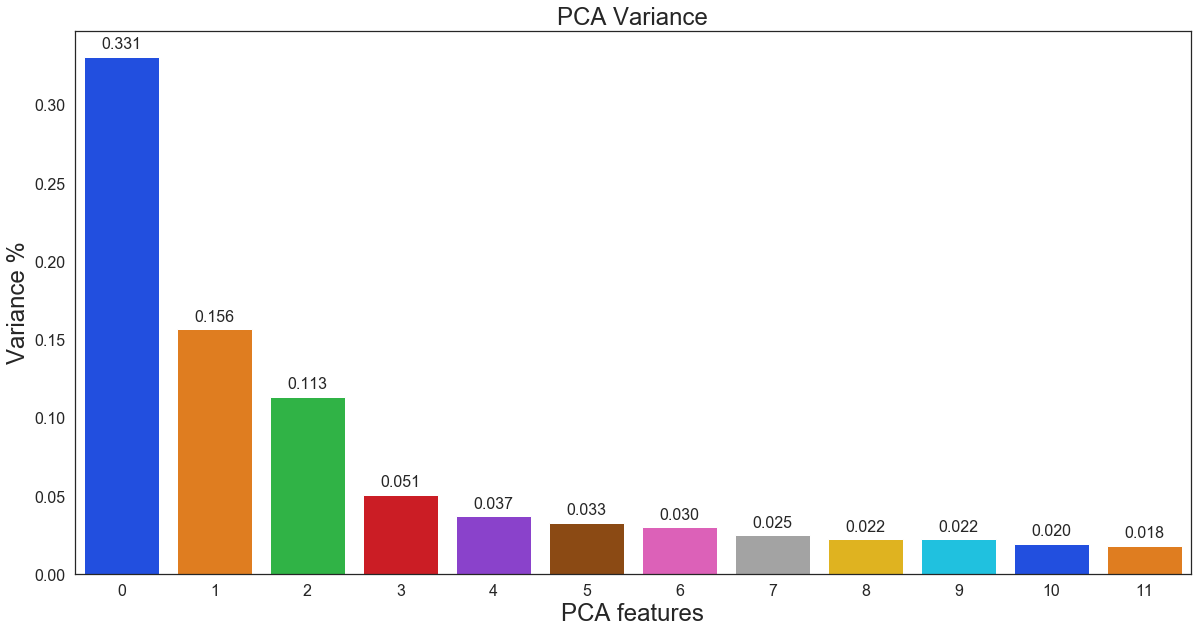

In [33]:
## Principle Components Analysis
# Set PCA parameters
pca = PCA(n_components = 12, random_state = 10)

# Fit and transform
principalComponents = pca.fit(X_train_std)
features = range(pca.n_components_)
principalComponents_variance = principalComponents.explained_variance_ratio_

# Plot the expected variance
plt.figure(figsize = (20,10))
sns.set(style = "white", rc = {"lines.linewidth": 3})
ax = sns.barplot(x = np.array(features), y = principalComponents.explained_variance_ratio_, palette = "bright")
plt.xlabel('PCA features', fontsize = 24)
plt.ylabel('Variance %', fontsize = 24)
plt.title('PCA Variance', fontsize = 24)
plt.xticks(features, fontsize = 16)
plt.yticks(fontsize = 16)

# Function to add labels to bar chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize = '16',            # Font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above
add_value_labels(ax)

plt.show()

Before, we begin with clustering we want to transform the training data using PCA.

In [ ]:
# Set PCA number of components
pca = PCA(n_components = 12, random_state = 10)

In [ ]:
def pca_Fit_Transform(df):
    """Function to fit and transform the dataframe and rename the PCA components"""
    PCA_DF = pca.fit_transform(df)
    PCA_DF = pd.DataFrame(PCA_DF)
    
    # Rename PCA column names
    x = (np.array(PCA_DF.columns)+1)
    columns = []
    for i in x:
        columns.append('PCA' + ' ' + str(i))
    PCA_DF.columns = columns
    
    return PCA_DF

In [ ]:
def pca_Transform(df):
    """Function to transform the dataframe and rename the PCA components"""
    PCA_DF = pca.transform(df)
    PCA_DF = pd.DataFrame(PCA_DF)
    
    # Rename PCA column names
    x = (np.array(PCA_DF.columns)+1)
    columns = []
    for i in x:
        columns.append('PCA' + ' ' + str(i))
    PCA_DF.columns = columns
    
    return PCA_DF

In [ ]:
PCA_components_train = pca_Fit_Transform(X_train_std)
PCA_components_dev = pca_Transform(X_dev_std)
PCA_components_test = pca_Transform(X_test_std)

### Clustering

#### K-means clustering

K-means clustering is an algorithm to classify or to group objects based on attributes/features into K number of groups [2]. The grouping is done by minimizing the sum of square of distances between data and the corresponding cluster centroid.
Algorithm:

1. Select K points randomly from the dataset as the centroids of the clusters.
2. Assign data points to centroids closest to it.
3. Recompute the centroid so that it is closest to all the data points allocated to that cluster.
4. Repeat step 2 and 3 until the algorithm converges.

##### Parameters

In K-means clustering, we'll be examining two parameters:

* How clusters are initialized
* The number of clusters

##### Initialization

Standard k-means clustering has a challenge initializing the cluster centroids. If a wrong cluster initialization is set, the clusters will be wrong. We'll be using the K-means +++ initialization to solve this issue by first initializing the cluster centroids before following the standard k-means clustering algorithm.

1. The first cluster is chosen uniformly at random from the data points that we want to cluster. This is similar to what we do in K-Means, but instead of randomly picking all the centroids, we just pick one centroid here
2. Compute the distance (D(x)) of each data point (x) from the cluster center that has already been chosen
3. Choose the new cluster center from the data points with the probability of x being proportional to (D(x))2
4. Repeat steps 2 and 3 until k clusters have been chosen



###### Optimal Number of Clusters
Now, we'll want to identify the optimal number of clusters [3]. We'll use the inertia between clusters and silhouette analysis as our internal scoring metrics because we do not have access to correctly labeled data.


Inertia is the within-cluster sum of squares. It calculates the variance of points in each cluster.

Silhouette Analysis measures the similarity of points in a cluster and the dissimilarity of points in neighboring clusters.

For our problem, SA provides a better solution because we are not looking for how points are similar in each cluster, but how they are separated.

------------------------------------------------------------------------------------------------------------------
We plot the number of clusters vs the inertia, to identify the optimal number of clusters by selecting the number that is the elbow-point in the graph, or the point in which the graph doesn't have a steep slope.

The elbow point is four clusters.

In [ ]:
# The number of clusters from 1 to 10
ks = range(1, 10)

inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k, init = 'k-means++', random_state = 10)
    
    # Fit model to samples
    model.fit(PCA_components_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    print('Inertia for %i Clusters: %0.4f' % (k, model.inertia_))

# Plot parameters
plt.figure(figsize = (20, 10))
plt.plot(ks, inertias, '-o', color = 'black')
plt.plot(4, inertias[3], '-o', color = 'red', markersize = 12)
plt.xlabel('Number of clusters', fontsize = 24)
plt.ylabel('Inertia', fontsize = 24)
plt.title('Optimal number of clusters (Inertia)', fontsize = 24)
plt.xticks(ks, fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

Silhouette analysis studies how similar and dissimilar neighboring cluster centroids are. We select the point which is closest to +1. In our case, two clusters have the greatest value following with four clusters.

Being able to distinguish between a player and a hacker by having two clusters is the perfect solution. But from my experience, I feel there would be more segmentation than a cheater and a player such as
* Beginner
* Experienced
* Professional
* Hacker

Nevertheless, we will explore all possible outcomes.

In [ ]:
# Number of clusters
ks = range(2, 10)
score = []

# Silhouette Method
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 10).fit(PCA_components_train)
    ss = metrics.silhouette_score(PCA_components_train, kmeans.labels_, sample_size = 10000)
    score.append(ss)
    print('Silhouette Score for %i Clusters: %0.4f' % (k, ss))

# Plot Parameters
plt.figure(figsize = (20, 10))
plt.plot(ks, score, '-o', color = 'blue')
plt.xlabel("Number of clusters", fontsize = 24)
plt.ylabel("Silhouette score", fontsize = 24)
plt.title('Optinimal number of clusters (Silhouette)', fontsize = 24)
plt.xticks(ks, fontsize = 18)
plt.yticks(fontsize = 18)

## Different markers and colors for first three points
s = ['D', 'D', 'D' ]
col = ['red','green','orange' ]
x = np.array([2, 3, 4, 3])
y = score[0:3]
for _s, c, _x, _y in zip(s, col, x, y):
    plt.scatter(_x, _y, marker = _s, c = c, s = 100)
    
## Annotate text
plt.text(1.90, score[0] + 0.005,
         str(round(score[0], 3)), size = 14, color = 'red', weight = 'semibold')

plt.text(2.97, score[1] + 0.005,
         str(round(score[1], 3)), size = 14, color = 'green', weight = 'semibold')

plt.text(3.90, score[2] + 0.005,
         str(round(score[2], 3)), size = 14, color = 'orange', weight = 'semibold')

plt.show()

#### Two Clusters

Begin with configuring all parameters for k-means clustering.

In [ ]:
# K means train
number_cluster = 2
kmeans = KMeans(n_clusters = number_cluster, init = 'k-means++', random_state = 10).fit(PCA_components_train)
labels = kmeans.labels_

Next, load in our function to plot our 3D scatter plots.

In [ ]:
def scatter3d_cluster(df, x, y, z, code, title):
    scatter  =  px.scatter_3d(df, x = x, y = y, z = z, color = code,  
                            color_discrete_sequence = px.colors.qualitative.Light24)
    
    scatter.update_layout(title = title, title_font = dict(size  =  30),
                          scene = dict(
                              xaxis = dict(
                                  backgroundcolor = "rgb(200, 200, 230)",
                                  gridcolor = "white",
                                  showbackground = True,
                                  zerolinecolor = "white",
                                  nticks = 10, ticks = 'outside',
                                  tick0 = 0, tickwidth  =  4,
                                  title_font  =  dict(size  =  16)),
                              yaxis  =  dict(
                                  backgroundcolor = "rgb(230, 200,230)",
                                  gridcolor = "white",
                                  showbackground = True,
                                  zerolinecolor = "white",
                                  nticks = 10, ticks = 'outside',
                                  tick0 = 0, tickwidth  =  4,
                                  title_font  =  dict(size  =  16)),
                              zaxis  =  dict(
                                  backgroundcolor = "rgb(230, 230,200)",
                                  gridcolor = "white",
                                  showbackground = True,
                                  zerolinecolor = "white",
                                  nticks = 10, ticks = 'outside',
                                  tick0 = 0, tickwidth  =  4,
                                  title_font  =  dict(size  =  16),
                              ),
                          ),
                          width  =  700
                         )
    return scatter.show()

Lastly, plot the data and let's label the data with our assumptions on how hackers are perceived.

Hackers tend to have higher combat statistics than the rest of the playerbase.


In [ ]:
## 3D Plot of Training Data
# Create and modify dataframe for the cluster column
PCA_components_train['Cluster'] = pd.Series(labels, index=PCA_components_train.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Humans", 1: 'Hackers'}
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster'].map(cluster_label_names)  

# Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_train , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 17055 humans and 3716 hackers. This seems to be an enormous amount of hackers, and I do not trust the results, maybe four clusters will provide a better result. Nevertheless, let's continue with predicting on the dev and test sets.


In [ ]:
PCA_components_train.groupby('Cluster_Labels').count()

Also, let's take a look at the scatter matrix of principal components. From our results, the first three components display distinct clusters.

In [ ]:
# Scattermatrix
fig = px.scatter_matrix(PCA_components_train, 
                        dimensions = ["PCA 1", "PCA 2", "PCA 3", "PCA 4"], 
                        color = 'Cluster_Labels', color_discrete_sequence = px.colors.qualitative.Light24)

## Remove diagonal plots
fig.update_traces(diagonal_visible = False)
## Plot Parameters
fig.update_layout(
    title = 'Scattermatrix of PCA components with Two Clusters',
    title_font = dict(size = 24),
    width = 1000,
    height = 1000,
    scene = dict(
        xaxis = dict(title_font = dict(size = 18)),
        yaxis = dict(title_font = dict(size = 18)),
    )   
)

fig.show()

##### Predicting on the dev set

Begin with predicting on the dev set.

In [ ]:
# K means clustering of Testing Data
predict_labels = kmeans.predict(PCA_components_dev)

Next, create the 3D scatter plots.

In [ ]:
# 3D Plot of Training Data
## Create and modify dataframe for the cluster column
PCA_components_dev['Cluster'] = pd.Series(predict_labels, index = PCA_components_dev.index)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Humans", 1: "Hackers"}
PCA_components_dev['Cluster_Labels'] = PCA_components_dev['Cluster'].map(cluster_label_names)  

## Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_dev , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 5859 humans and 1262 hackers.


In [ ]:
PCA_components_dev.groupby('Cluster_Labels').count()

##### Predicting on the test set

Begin with predicting on the test set.

In [ ]:
# K means clustering of Testing Data
predict_labels = kmeans.predict(PCA_components_test)

Next, create the 3D scatter plots.

In [ ]:
# 3D Plot of Training Data
#@ Create and modify dataframe for the cluster column
PCA_components_test['Cluster'] = pd.Series(predict_labels, index = PCA_components_test.index)

#@ Rename Cluster label names from k-means
cluster_label_names = {1: "Hackers", 0: "Humans"}
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster'].map(cluster_label_names)  

#@ Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_test , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 1485 humans and 296 hackers.

In [ ]:
PCA_components_test.groupby('Cluster_Labels').count()

#### Four Clusters

Begin with performing PCA on dataframes.

In [ ]:
# Set PCA number of components
pca = PCA(n_components = 12, random_state = 10)

# Set PCA_dataframes
PCA_components_train = pca_Fit_Transform(X_train_std)
PCA_components_dev = pca_Transform(X_dev_std)
PCA_components_test = pca_Transform(X_test_std)

Next, configure all parameters for k-means clustering.

In [ ]:
# K means train
number_cluster = 4
kmeans = KMeans(n_clusters = number_cluster, init = 'k-means++', random_state = 10).fit(PCA_components_train)
labels = kmeans.labels_

Next, plot the data.

In [ ]:
## 3D Plot of Training Data
# Create and modify dataframe for the cluster column
PCA_components_train['Cluster'] = pd.Series(labels, index = PCA_components_train.index)

#Rename Cluster label names from k-means
cluster_label_names = {2: "Experienced", 0: "Beginner", 1: "Professional", 3: "Hacker"}
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster'].map(cluster_label_names)  

# Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_train , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 12196 beginners, 4383 experienced, 3528 professionals, and 664 hackers. This seems more reasonable in how many hackers were selected, as I'd expect hackers to take up a small number of the population roughly 0 to 10%.


In [ ]:
PCA_components_train.groupby('Cluster_Labels').count()

Also, let's take a look at the scatter matrix of principal components. From our results, the first three components display distinct clusters.

In [ ]:
# Scattermatrix
fig = px.scatter_matrix(PCA_components_train, 
                        dimensions = ["PCA 1", "PCA 2", "PCA 3", "PCA 4"], 
                        color = 'Cluster_Labels', color_discrete_sequence = px.colors.qualitative.Light24)
## Remove diagonal plots
fig.update_traces(diagonal_visible = False)

## Plot Parameters
fig.update_layout(
    title = 'Scattermatrix of PCA components with Four Clusters',
    title_font = dict(size = 24),
    width = 1000,
    height = 1000,
    scene = dict(
        xaxis = dict(title_font = dict(size = 18)),
        yaxis = dict(title_font = dict(size = 18)),
    )
)

fig.show()

##### Predicting on the dev set

Begin with predicting on the dev set.

In [ ]:
# # K means clustering of Testing Data
predict_labels = kmeans.predict(PCA_components_dev)

Next, create the 3D scatter plots.

In [ ]:
## 3D Plot of Training Data
# Create and modify dataframe for the cluster column
PCA_components_dev['Cluster'] = pd.Series(predict_labels, index = PCA_components_dev.index)

#Rename Cluster label names from k-means
cluster_label_names = {2: "Experienced", 0: "Beginner", 1: "Professional", 3: "Hacker"}
PCA_components_dev['Cluster_Labels'] = PCA_components_dev['Cluster'].map(cluster_label_names)  

# Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_dev , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 4174 beginners, 1508 experienced, 1206 professionals, and 233 hackers.

In [ ]:
PCA_components_dev.groupby('Cluster_Labels').count()

##### Predicting on the test set

Begin with predicting on the test set.

In [ ]:
# K means clustering of Testing Data
predict_labels = kmeans.predict(PCA_components_test)

Next, create the 3D scatter plots.

In [ ]:
# 3D Plot of Training Data
## Create and modify dataframe for the cluster column
PCA_components_test['Cluster'] = pd.Series(predict_labels, index = PCA_components_test.index)

## Rename Cluster label names from k-means
cluster_label_names = {2: "Experienced", 0: "Beginner", 1: "Professional", 3: "Hacker"}
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster'].map(cluster_label_names)  

## Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_test , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 1030 beginners, 397 experienced, 313 professionals, and 41 hackers.

In [ ]:
PCA_components_test.groupby('Cluster_Labels').count()

### Remarks
* Without external labels, we cannot verify the accuracy of these clusters. But we can make an educated guess on what these clusters are by using domain experience and advice from experts playing the game.
* Also, it's difficult to interpret the results of the PCA components because we do not know what features are included.

### References
[1] https://www.cs.cmu.edu/~elaw/papers/pca.pdf

[2] "Survey Report on K-Means Clustering Algorithm", International Journal of Modern Trends in Engineering & Research, vol. 4, no. 4, pp. 218-221, 2017. Available: 10.21884/ijmter.2017.4143.lgjzd.

[3] https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/